In [31]:
import re
import random
import pandas as pd
import hashlib

In [32]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
threshold = .005+(mean/1000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.184993; threshold=0.055072


In [33]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(sum_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
ODBC,21.924844,1.370303,8.286383,16
Power BI,41.387025,13.795675,18.547028,3
Network Terms,374.054711,24.936981,44.126566,15
Ubuntu,590.351301,22.705819,78.920115,26
GUI Docker Container,640.305745,30.490750,59.852024,21
WinHex,864.086271,43.204314,142.400909,20
SSH + SCP,888.741219,30.646249,106.137523,29
Django,897.427616,64.101973,238.409151,14
"Everything is Tuberculosis, Green",947.179021,41.181697,212.725547,23
CCH Tax Forms Project,1048.328962,61.666410,143.390094,17


# Histogram

sum of ages: ~38844.90


<Axes: >

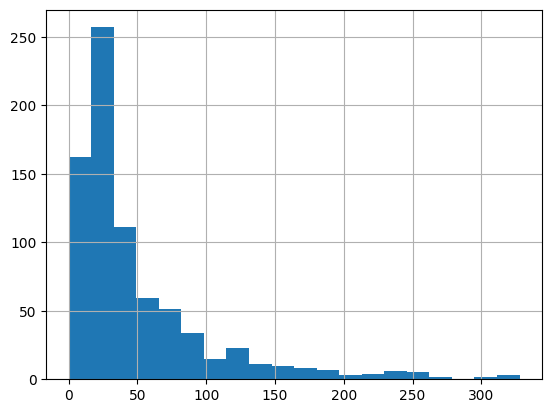

In [34]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~38844.90


<Axes: >

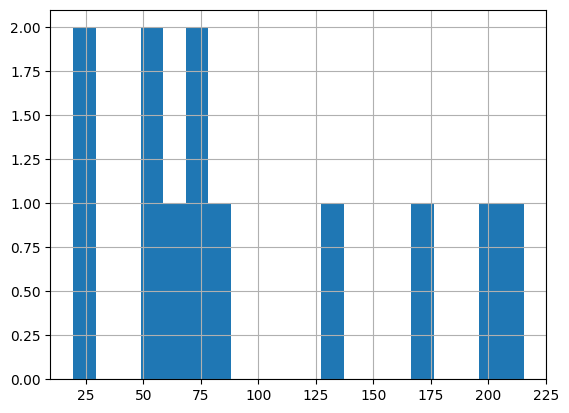

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python + Oauth2.0']['age'].hist(bins=20)

# Completely Random Shuffle

In [36]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [37]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [38]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [39]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 773
Total card age: 38844.90


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
31,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,-215.410982,-98.194696,215.410982,1178.336357,0.117109,12,0,0
112,Python + Oauth2.0,urllib.parse.urlparse / parse_qs\n\nFunctions ...,dbda74d818c5c30a0cfc7056c7835710,-134.696117,-98.194696,215.410982,1178.336357,0.117109,12,3,0
190,Python + Oauth2.0,handler.send_response()\n\nSends an HTTP statu...,9e122d4cc8f3b562301020929b943bf6,-74.956237,-98.194696,215.410982,1178.336357,0.117109,12,6,0
268,Python + Oauth2.0,do_GET()\n\nA method in `SimpleHTTPRequestHand...,78fddfec4724e43f645ad45915fabef9,-49.864863,-98.194696,215.410982,1178.336357,0.117109,12,9,0
22,"The Simulacra, Dick",pert face (PERT fays)\nnoun\nA face that looks...,fe52eef7f1879bcda8fe042ce944f16a,-236.485649,-83.703507,236.485649,1590.366633,0.001829,19,0,0
103,"The Simulacra, Dick",tropism (TROH-piz-um)\nnoun\nA biological tend...,4935105d8a38575a1621e03a74db709e,-126.703996,-83.703507,236.485649,1590.366633,0.001829,19,3,0
181,"The Simulacra, Dick",C. Wright Mills (SEE RYTE MILZ)\nproper noun\n...,d721800ce688827969fb6af3e61746cc,-86.747626,-83.703507,236.485649,1590.366633,0.001829,19,6,0
259,"The Simulacra, Dick",mohair sweater (MO-hair SWET-er)\nnoun\nA soft...,6de584ed85b3b3585586d50cc5ff8467,-80.190473,-83.703507,236.485649,1590.366633,0.001829,19,9,0
261,"The Simulacra, Dick",ukases of the supreme communist authority (YOO...,f79593533df1908fd240ddf044e81a32,-63.605873,-83.703507,236.485649,1590.366633,0.001829,19,12,0
410,"The Simulacra, Dick",paresis (puh-REE-sis)\nnoun\nMild or partial p...,1b9e3d9f6d07ca37f45e418c16809324,-42.752515,-83.703507,236.485649,1590.366633,0.001829,19,15,0


## Age Max

In [40]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [41]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [42]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [43]:
existing_cards.head(10)['age'].sum()

np.float64(-1111.414330743416)

In [44]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
1,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,-327.736738,-81.127315,327.736738,3082.837967,0.644669,38,0,0
4,Terraform Codebox,"In a Terraform module, names like ""main"" or ""t...",1b7ed79374e4be64070aa3e191990353,-320.379419,-60.208761,320.379419,1806.262822,0.473509,30,0,0
2,Microsoft Purview,Data understanding is about ensure data has qu...,9a95bac80e7ba590c49d6bcab8edaf38,-315.357539,-81.127315,327.736738,3082.837967,0.644669,38,1,1
7,Azure Functions Core Tools,Get-Command (PowerShell) – Finds which executa...,0635fb1571b8f8e4280232ceb6070d75,-299.576800,-70.721341,299.576800,1202.262801,0.322603,17,0,0
3,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,3c753353c6695bdcff7b2121467b00ed,-299.220200,-81.127315,327.736738,3082.837967,0.644669,38,2,2
82,Microsoft Purview,DLP policies can be applied to the following l...,1e0d0df316a1863273287a159447b6b6,-265.698684,-81.127315,327.736738,3082.837967,0.644669,38,3,0
10,JavaScript Concepts,"For objects, by default String returns an unhe...",cc7c3bc61969fcf92a11320dd7feed10,-262.745090,-70.826640,262.745090,2337.279126,0.474714,33,0,0
5,Terraform Codebox,curl -L -o filename\nA command to download fil...,9579c5ea9be6402b1e145491fbb73226,-261.944152,-60.208761,320.379419,1806.262822,0.473509,30,1,1
13,Linux,Process\nA running instance of a program with ...,f5a712ebdaa4ff23d911d97a945af7a8,-261.766934,-50.571122,261.766934,1618.275890,0.998448,32,0,0
14,Linux,systemctl\nThe primary tool for managing syste...,f03e0a8bdc15dc87679738720aa92309,-255.577470,-50.571122,261.766934,1618.275890,0.998448,32,1,1


In [45]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 50.252'